> ## Introduction

**Swin Transformer** is a hirarchical vision transformer that was published in 2021 and selected as the best paper at ICCV 2021. Transformer has been extensively used in Natural Language Processing fields since **Attenion Is All You Need** paper came out in 2017 which uses **attention** mechanism. Many efforts have been made such as **ViT** to apply transformer to computer vision fields. The Vision Transformer(ViT) was successful in image classification but had drawbacks: 1) suboptimal for dense prediction such as semantic segmentation and object detection, 2) quadratic computational complexity to the input size due to the global attention computation.

Challenges to apply Transformer from NLP to computer vision tasks comes from the intrinsic differences between the nature of them including 1) large variations in the scale of visual entities and 2) high resolution of pixels in images. Swin Transformer uses **hierarchical architecture** to address those issues where the represntation is computed with **S**hifted **win**dows.

The authors suggest that Swin Transformer could be potentially used as a general-purpose **backbone** for computer vision.

**[Note]** In this post, we'll go over the fundamental concepts of Swin Transformer without the full explanation of implementation details (Although some provided). In the other post, detailed implementation guides are provided (check out the link in the bottom). The implementation is from the [official PyTorch Implementation](https://github.com/microsoft/Swin-Transformer) with some modifications and very detailed comments.

> ## Hierarchical Feature Maps

Transformers have been applied for computer vision not only for NLP as ViT showed great performance especially for classification tasks. However, the existing transformers (as of 2021) result in **suboptimal** performance in many computer vision applications due to,

1. **Fixed token scale** for attention - unsuitable for dense predictions like object detection and semantic segmentation
2. **Bad computational complextiy** (quadratic to image size)

Swin Transformer addresses the first problem with **hierarchical feature map** which starts with **small-sized patches and gradually merges neighboring patches** (patch merging) as the network gets deeper. Intuitively, this hierarchical feature map could potentially capture smaller features of the visual entities, thus enhancing the dense prediction capability.

| 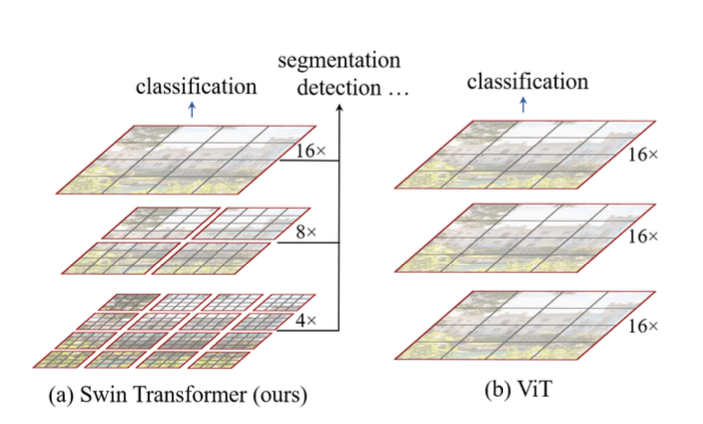 |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.1* |

> ## Linear Computational Complexity

The existing vision transformers like ViT has quadratic computational complexity, making it inefficient for high-resolution computer vision tasks.

Swin Transformer performs self-attention locally within **non-overlapping** windows (outlined in red in Fig.1) THe number of patches in each window is **fixed**, thus making the computational complexity linear to image size.

> ## Shifted Window

The key design element of Swin Transformer is the **shifted window** between consecutive self-attention layers as illustrated in the Fig. 2

| 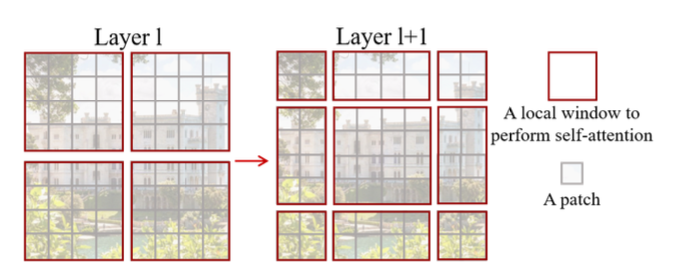 |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.2* |

As stated earlier, Swin Transformer divides an image into windows and perform self-attention within each window locally. However, it doesn't efficiently captures connections between windows. Thus, shifted window approach provides connections among the consecutive windows which show significant enhancements of modeling power.

> ## Swin Transformer Architecture

Below figure is the overview of the Swin Transformer architecture (Swin-T). In the following sections, we'll go over one by one in the architecture.

| 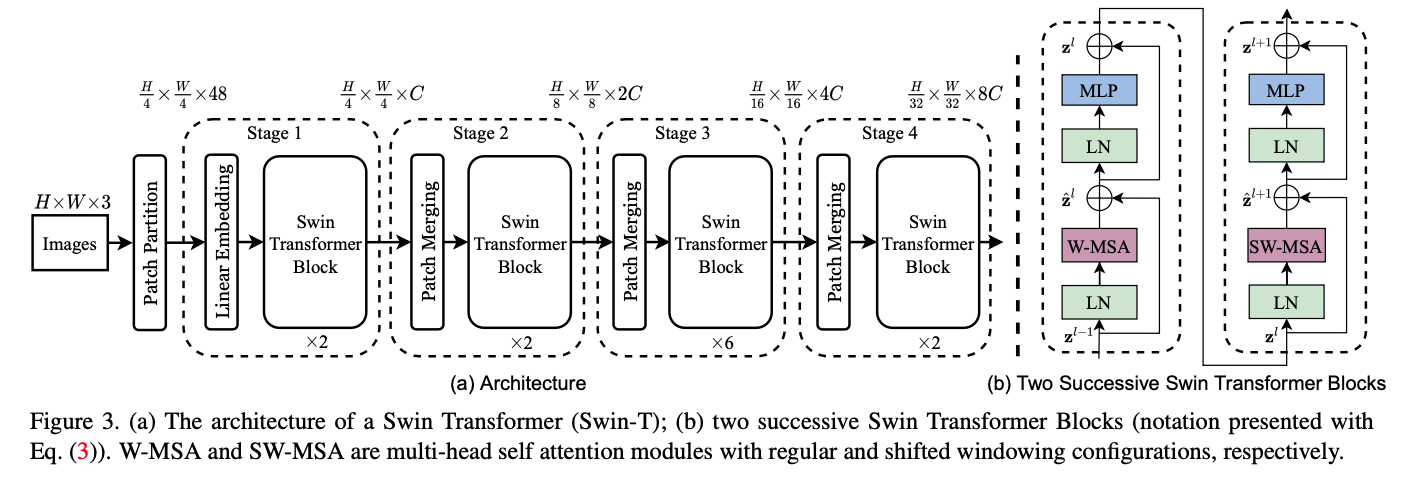 |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.3* |

> ## Patch Partition

Before feeding into the swin transformer blocks, we first need to perform **patch partition** on the RGB input image to convert to **non-overlapping patches**. Each patch is treated as a **token** for attention and its feature is set as a **concatenation of the raw pixel RGB values** which means we flatten all the pixels in each patch (token). In the paper, **patch size = 4 x 4**. Thus, the feature dimension for one patch is $4 \times 4 \times 3 = 48$ including RGB channel dimension. Before we move on, let's see the number details which are important to understand the overall architecture.

* **image_resolution** = `224 x 224`

* **patch_size** = `4 x 4` in terms of pixels per height/width

* **number of pixels(features) in one patch** = `4 x 4 x 3` = `48`

* **total number of patches** in the whole image = `224/4 x 224/4` = `3136`

* **window_size** = `7 x 7` in terms of patches per height/width

* **number of patches** in one window = `7 x 7` = `49`

* **total number of windows** in the whole image = `224/4/7 x 224/4/7` = `8 x 8` = `64`

```python
def window_partition(x, window_size=7):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size (Default: 7)
        
    Returns:
        windows: (num_windows * B, window_size, window_size, C)
                 (8*8*B, 7, 7, C)
    """
    
    B, H, W, C = x.shape
    
    # Convert to (B, 8, 7, 8, 7, C)
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    
    # Convert to (B, 8, 8, 7, 7, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B*8*8, 7, 7, C)
    windows = windows.view(-1, window_size, window_size, C)
    
    
    return windows
```

> ## Linear Embedding Layer

A **linear embedding layer** is applied on this feature concatenation to project it to an arbitrary dimension (denoted as **C**). In the official implementation, **patch partition** and **embedding** are simultaneously done with `nn.Conv2d` with `kernel_size=patch_size`, `stride=patch_size`. Although the architecture in the paper first performs patch partition and the linear embedding, the official implementation **first performs embedding**(both partition & embedding) and uses **window partition** module after.

```python
class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x
```

> ## Swin Transformer Block

| 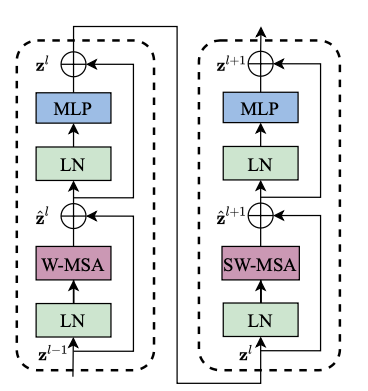 |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.4* |

The Figure 4 shows the **swin transformer block** which is the fundamental building block of Swin Transformer. It replaces the standard multi-head self-attention (MSA) module by two types of multi-head self-attention modules: **W-MSA** (window-based MSA) and **SW-MSA** (shifted-window-based MSA). The swin transformer block also uses **layer normalization layer** is applied before each MSA module and each MLP module. Also, a residual connection (from ResNet) is applied after each module.

| 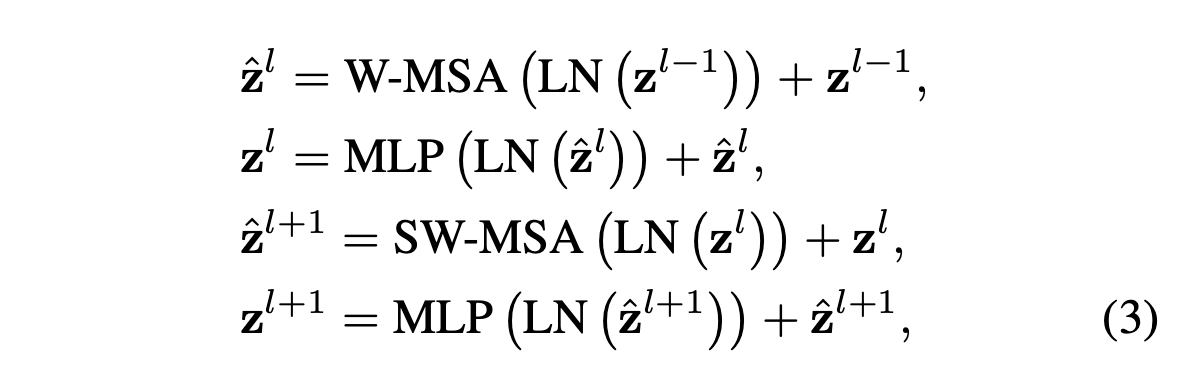 |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.5* |

The above shows the computations of two consecutive transformer blocks (W-MSA and SW-MSA) where $\hat{z}^l$ and $z^l$ denote the output features of the (S)W-MSA module and the MLP module for block $l$.

Swin Transformer block is repeated a few times according to the architectural design which we will talk about later on.

> ## Shifted-Window based Self-Attention

### Self-attention in non-overlapping windows (W-MSA)

The left transformer block in Fig. 4 illustrates **Window-based MSA** (W-MSA). An input image is partitioned into `M x M` windows and self-attention is performed within each window locally. Consequently, the computational complexity is improved. The following are the computational complexity for a **global MSA module** and **W-MSA**, consequently.

$$\Omega(MSA)=4hwC^2 + 2(hw)^2$$

$$\Omega(W-MSA)=4hwC^2 + 2M^2hwC$$

The global MSA module is has a quadratic computational complexity to patch number $hw$ while the window-based MSA module has a **linear complexity** when $M$ is fixed ($M$=7)

### Shifted window partitioning in successive blocks (SW-MSA)

The right transformer block in Fig. 4 illustartes **Shifted window-based MSA** (SW-MSA). W-MSA **cannot provide connections between windows** as self-attention is performed only within each window, limiting the modeling power. To provide connections between windows while maintaining computational efficiency, **shifted window partitioning approach** is proposed in this paper.

| 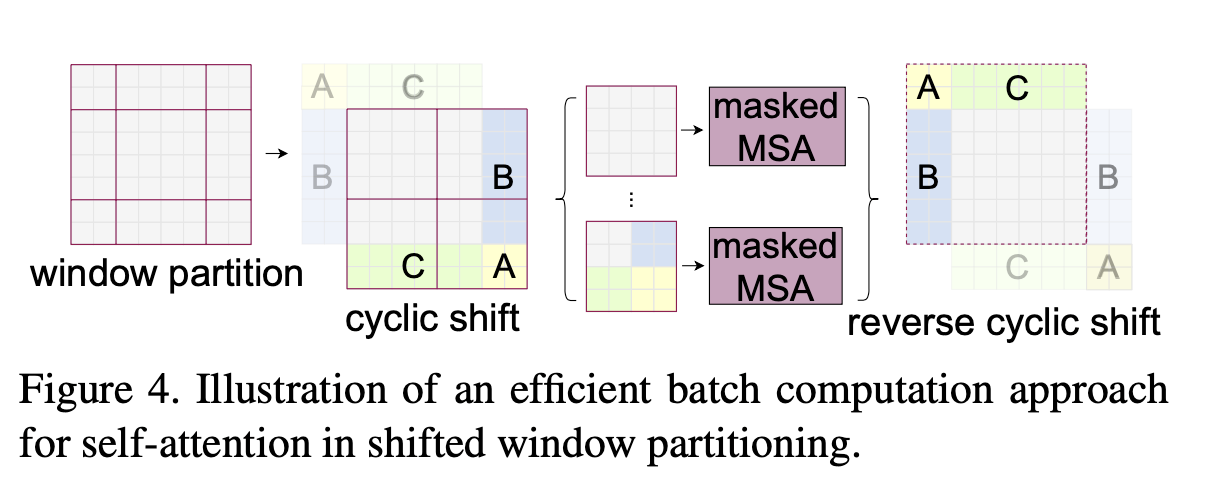 |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.6* |

| 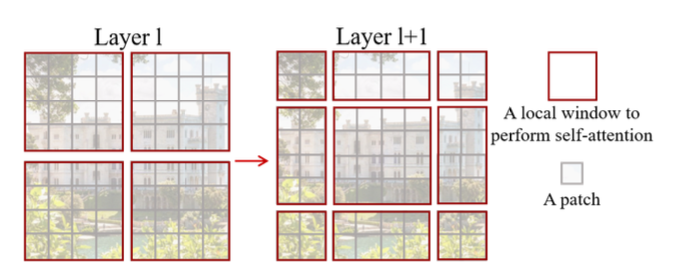 |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.2* |

In layer $l$, the regular window partitioning is performed with equal size of window. In the next layer $l+1$, window partitioning is **shifted** as shown in the right side of Fig 2. The window is shifted from the left figure by displacing the windows by $(\lfloor \frac{M}{2} \rfloor, \lfloor \frac{M}{2} \rfloor)$. So the shift size is **2** in this example since the window size $M=4$.

| 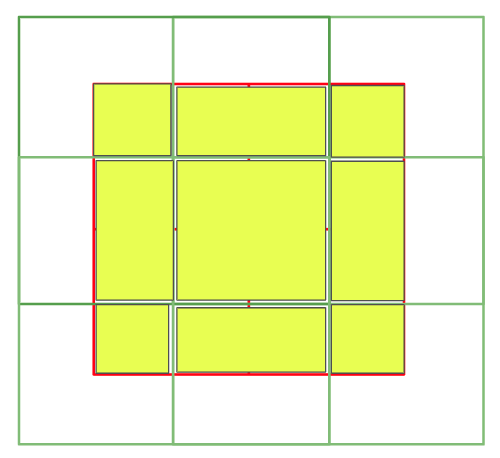 |
|:--:|
| *Fig.7* |

Now, the newly created **9 windows** provide **interconnections** between the original neighboring 4 windows. However, there're a total of **9 windows** now but the author suggests another technique called **cyclic shift** to re-assemble these 9 windows back into 4 windows.

> ## Cyclic Shift

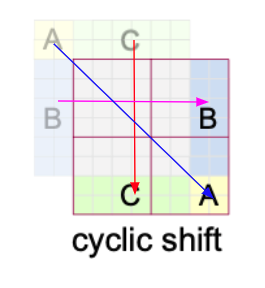
|:--:|
| *Fig.8* |

To match the original `M x M` window size, each of the A, B, C regions are **shifted** as shown in the diagram. The implementation of cyclic shift is quite simple using `torch.roll`. If we "roll" or cyclically shift in the negative directions for both dimensions, we can easily achieve the cyclic shift.

In [1]:
import torch
a = torch.tensor([
    [1, 1, 2, 2, 2, 2, 2, 2],
    [1, 1, 2, 2, 2, 2, 2, 2],
    [3, 3, 0, 0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0, 0, 0, 0],
    [3, 3, 0, 0, 0, 0, 0, 0]
])

torch.roll(a, shifts=(-2, -2), dims=(0, 1))

tensor([[0, 0, 0, 0, 0, 0, 3, 3],
        [0, 0, 0, 0, 0, 0, 3, 3],
        [0, 0, 0, 0, 0, 0, 3, 3],
        [0, 0, 0, 0, 0, 0, 3, 3],
        [0, 0, 0, 0, 0, 0, 3, 3],
        [0, 0, 0, 0, 0, 0, 3, 3],
        [2, 2, 2, 2, 2, 2, 1, 1],
        [2, 2, 2, 2, 2, 2, 1, 1]])

After cyclic shift, we again partition into `M x M` windows like the original partition.

But still we need to deal with another problem. Remember that the core concept of Swin Transformer is that **self-attention is performed only within each window locally**. However, As you can see in the Fig. 9, one window(newly created window) contains parts of different windows(from the perspective of before cyclic shift).

| 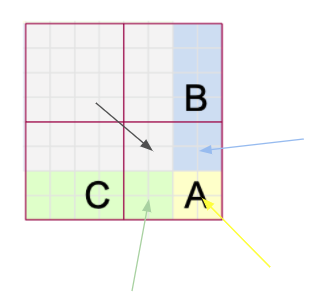 |
|:--:|
| *Fig.9* |

This is not good.. we need to make sure that self-attention is performed only within each window from the perspective of **original 9 windows** before the cyclic shift. How can we do that? That's why we need **attention mask** as shown in Fig. 6.

| 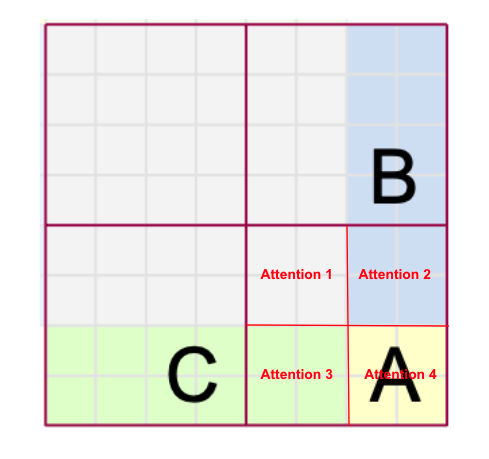 |
|:--:|
| *Fig.10* |

Take the bottom-right window as an example. This window consists of 4 different (colored) windows (before cyclic shift). Therefore, we need to somehow perform attention individually for each region as shown in the figure. How can we do this? Let's first take a look at the official implemention.

```python
if self.shift_size > 0:
            H, W = self.input_resolution
            
            # To match the dimension for window_partition function
            img_mask = torch.zeros((1, H, W, 1))
            
            # h_slices and w_slices divide a cyclic-shifted image to 9 regions as shown in the paper
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )
            
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )
            
            # Fill out number for each of 9 divided regions
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
                    
            mask_windows = window_partition(img_mask, self.window_size) # (nW, M, M, 1)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            
            # Such a gorgeous code..
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
            
        self.register_buffer('attn_mask', attn_mask)
```

Let's dive deep into the codes.

| 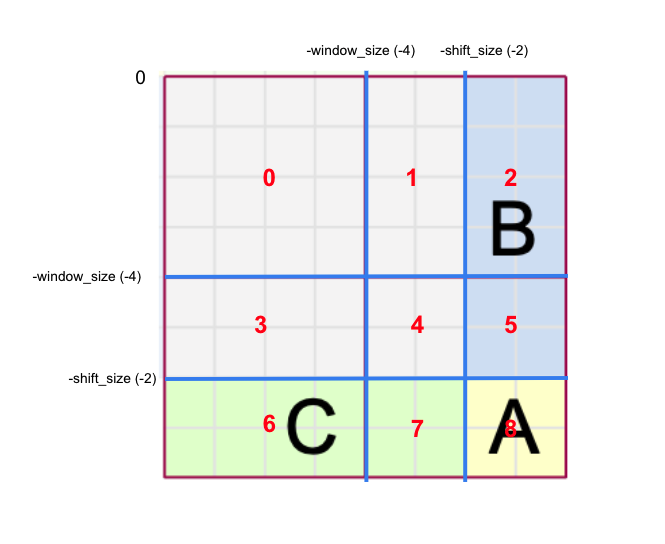 |
|:--:|
| *Fig.11* |

1. Slice the indices into `[0: -window_size]`, `[-window_size: -shift_size]`, and `[-shift_size:]` for both horizontally and vertically. Then we get these 9 partitions as shown in the Figure 11.

```python
# h_slices and w_slices divide a cyclic-shifted image to 9 regions as shown in the paper
    h_slices = (
        slice(0, -self.window_size),
        slice(-self.window_size, -self.shift_size),
        slice(-self.shift_size, None)
    )

    w_slices = (
        slice(0, -self.window_size),
        slice(-self.window_size, -self.shift_size),
        slice(-self.shift_size, None)
    )
```

2. Assign numbers `0 ~ 8` to **each patch** of the divided regions (numbers are drawn region-wise for simplicity).

```python
 # Fill out number for each of 9 divided regions
    cnt = 0
    for h in h_slices:
        for w in w_slices:
            img_mask[:, h, w, :] = cnt
            cnt += 1
```

3. Perform **window partitioning** with equal size of window (`M x M`). After the partition, we have a total of 4 windows. The first window has region `0`, the second has `1, 2`, the third has `3, 6`, and the fourth has `4, 5, 7, 8`.

```python
    mask_windows = window_partition(img_mask, self.window_size) # (nW, M, M, 1)
    mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
```

4. **For each of the window**, perform self-attention **individually for each region number** by applying **attention masks**. The implementation of this separate self-attention is the beauty I think. Remember that we apply this separate self-attention when we're dealing with self-attention, meaning $qk^{\top}$ which has $M^2 \times M^2$ shape. **(More details below)**.

```python
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
```

5. For attention mask, set to `0` for regions we want to apply self-attention, other wise a small number like `-100` for regions we don't want to apply self-attention.

```python
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
```


6. Later when we get $qk^{\top}$ add this attention-mask.

7. Perform **reverse cyclic shift**.

```python
    def window_reverse(windows, window_size, H, W):
        """
        Args:
            windows: (num_windows * B, window_size, window_size, C)
                     (8*8*B, 7, 7, C)
            window_size (int): window size (default: 7)
            H (int): Height of image (patch-wise)
            W (int): Width of image (patch-wise)

        Returns:
            x: (B, H, W, C)
        """

        # Get B from 8*8*B
        B = int(windows.shape[0] / (H * W / window_size / window_size))

        # Convert to (B, 8, 8, 7, 7, C)
        x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)

        # Convert to (B, 8, 7, 8, 7, C)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()

        # Convert to (B, H, W, C)
        x = x.view(B, H, W, -1)

        return x
```

> ## Attention Mask

Let's take an example of **bottom-left** window from Fig 11. As stated earlier, we want to apply self-attention individually for each region(separately for `3` and `6`) in this window as shown in Fig 12.

| 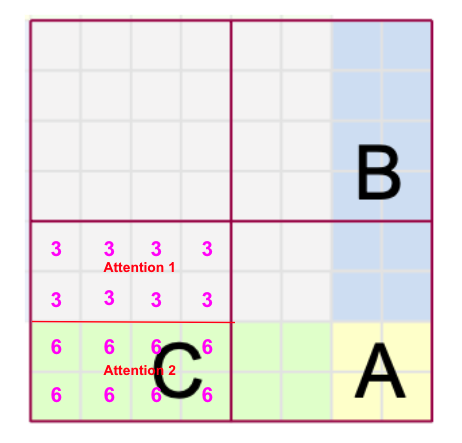 |
|:--:|
| *Fig.12* |

But how do we do this? The official implementation uses a nice yet super simple trick to achieve this. Follow each step along with the figure 13.

1. First, create two duplicates of the same window with shape `M x M` for each window (`nW` means total number of windows)
2. Flatten `M x M` to `M^2` for each window.
2. `unsqueeze` one dimension vertically for one duplicate and horizontally for the other one.
3. Subtract the duplicates to obtain the `M^2 x M^2` shape attention-mask matrix.
4. Make all the **non-zero** patches to `-100`.

| 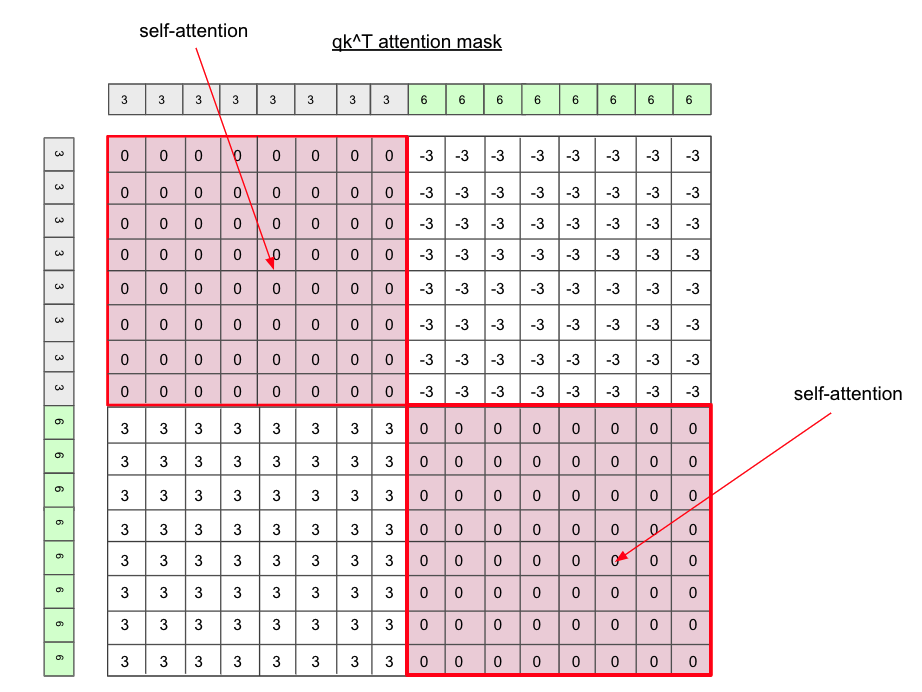 |
|:--:|
| *Fig.13* |

Since each patch has its own **region number** assigned, if we perform the subtraction, the same regions' number will be `0`. We only perform self-attention for patches with number `0`. Everything else will be set to `-100` so that self-attention is not performed.

> ## Efficient Batch Computation for shifted configuration

As we discussed earlier, we used **cyclic-shifting** and **attention mask** to convert 9 windows back to 4 windows for more efficient batch computation.

Also, in the implementation of the cyclic shift, all the windows go into the **batch dimension** for more efficient batch computation. Let's see what it means with codes.

```python
    mask_windows = window_partition(img_mask, self.window_size) # (nW, M, M, 1)
    mask_windows = mask_windows.view(-1, self.window_size * self.window_size) # (nW, M^2)
```

In the second line, `nW = B * num_windows` so we're putting windows into the batch dimension for more efficient computation.

> ## Relative Position Bias

Another key component of Swin Transformer is **relative position bias** $B$. Unlike absolute position embedding, relative position bias literally tells us **relative position information** of the patches in a window. The relative position bias matrix $B$ is added after $\frac{QK^{\top}}{\sqrt{d}}$ as shown below.

$$Attention(Q,K,V)=Softmax \left( \frac{QK^{\top}}{\sqrt{d}} + B \right)V$$

where $Q,K,V \in \mathbb{R}^{M^2 \times d}$ are the query, key, and value matrixes and $d$ is the query/key dimension and $M^2$ is the number of patches in a window.

Since a window size is `M x M`, the relative position **along each axis** lies in the range $[-M+1, M-1]$ as shown in the Fig 14.

| ![space-1.jpg](../images/swint14.png) |
|:--:|
| *Fig.14* |

For more efficient calculation, we use smaller-sized bias matrix $\hat{B} \in \mathbb{R}^{(2M-1) \times (2M-1)}$ and the values in $B$ are **taken** from $\hat{B}$.

The following are the complete steps of relative position bias. Note that the **window size** is `M=7` in the actual implementation.

1. Construct **x-axis relative position matrix** and **y-axis relative position matrix** whose element's value lies in the range $[-M+1, M-1]$. (I will call x-axis matrix and y-axis matrix in short from now on)

2. Add `M - 1` to x-axis matrix and y-axis matrix. So the element's value lies in the range $[0, 2M-2]$.

3. Multiply `2M-1` **only to** the x-axis matrix ([Youtube Channel](https://www.youtube.com/watch?v=2lZvuU_IIMA)) suggested that the reason we do this only for x-axis might be that most of the things have left-right symmetry and I think this is reasonable. Now, the range of x-axis matrix becomes $[0, (2M-1)(2M-2)]$ while the y-axis matrix's range still remains as $[0, 2M-2]$.

4. Finally, add x-axis matrix and y-axis matrix. The resulting matrix has the element range $[0, (2M-1)(2M-2)+2M-2] = [0, 4M^2-4M] = [0, (2M-1)^2 - 1]$. Why `(2M-1)^2 - 1`? Recall the actual values for $B$ are **taken** from $\hat{B}$ which has `(2M-1, 2M-1)` shape so its **index** ranges in `[0, (2M-1)^2 - 1]`. Therefore, the matrix we just constructed by adding x-axis matrix and y-axis matrix is **relative position matrix** which contains the **index** of the bias matrix $\hat{B}$ which is actually a matrix of **learnable parameters**.

> ## Architecture Variants

| ![space-1.jpg](../images/swint18.png) |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.18* |

Great job! They were not that easy to understand right? But you've made it! Now, let's talk about some variations of Swin Transformer. Different variants are introduced such as **Swin-T, Swin-S and Swin-L** which are versions of about `0.25x`, `0.5x` and `2x` the model size and computational complextiy, respectively.

The following are the configurations set for all experiments:

* window size: `M = 7`
* query dimension of each head: `d = 32`
* expansion layer of each MLP: `alpha = 4`

The following are hyper-parameters of the model variants:

* **Swin-T**: `C = 96`, layer numbers = `[2, 2, 6, 2]`
* **Swin-S**: `C = 96`, layer numbers = `[2, 2, 6, 2]`
* **Swin-B**: `C = 128`, layer numbers = `[2, 2, 18, 2]`
* **Swin-L**: `C = 192`, layer numbers = `[2, 2, 18, 2]`

where `C` is the channel number of the hidden layers in the first stage.

> ## Experiments

### Image Classification on ImageNet

| ![space-1.jpg](../images/swint19.png) |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.19* |



### Object Detection on COCO

| ![space-1.jpg](../images/swint20.png) |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.20 |


### Semantic Segmentation on ADE20K

| ![space-1.jpg](../images/swint21.png) |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.21* |


### Ablation Study on Shifted Window

| ![space-1.jpg](../images/swint22.png) |
|:--:|
| *[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf)* |
| *Fig.22* |

> ## Full PyTorch Implementation

You can find the full implemention in https://github.com/JasonLee-cp/pytorch/blob/main/transformers/swin_transformer.ipynb This is based on the official implementation you can find in References [2]. I've added detailed comments and made some modifications to make it easier to understand. I'm planning to make another posting giving detailed implementation guides soon.

> ## References

[1] https://arxiv.org/pdf/2103.14030.pdf    
[2] https://github.com/microsoft/Swin-Transformer     
[3] https://towardsdatascience.com/swin-vision-transformers-hacking-the-human-eye-4223ba9764c3     
[4] https://www.youtube.com/watch?v=2lZvuU_IIMA    
[5] https://www.youtube.com/watch?v=SndHALawoag